In [1]:
from trpo import *
from utils import *
from gym_env.environments import create_halfcheetah_env

## Train TRPO

In [ ]:
render = False
forward_reward_weight = 1
env = create_halfcheetah_env()

value_learning_rate = 0.005
hidden_dim = 32

policy_net = CreatePolicyNet(env, hidden_dim)
value_net = CreateValueNet(env, hidden_dim, value_learning_rate)

hyperparams = {"epochs":2000, 
                "num_episodes":50, 
                "max_num_steps":200, 
                "max_d_kl" : 0.01, 
                "damping_coeff" : 0.1, 
                "entr_coeff" : 0.05}
# hyperparams = {"epochs":1000, 
#                 "num_episodes":10, 
#                 "max_num_steps":200, 
#                 "max_d_kl" : 0.01, 
#                 "damping_coeff" : 0.1, 
#                 "entr_coeff" : 0.05}

trpo = TRPO(env, policy_net, value_net, hyperparams) 
trpo.train_trpo()

## Load TRPO Policy

In [ ]:
temp_env = create_halfcheetah_env()
loaded_policy = CreatePolicyNet(temp_env)
loaded_policy.load_state_dict(torch.load((TRPO_WEIGHTS_PATH / 'policy_net_weights.pth').as_posix()))

/var/folders/nr/lfk3812x5593gr3r977z3s500000gn/T/ipykernel_8298/2841495747.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_policy.load_state_dict(torch.load("trpo

<All keys matched successfully>

In [ ]:
try_policy(loaded_policy)

## Generate Expert Data from TRPO policy

In [ ]:
import time
seed = 1
max_num_steps = 200
num_episodes = 50000

env = create_halfcheetah_env()

trajectories = []

with tqdm(total=num_episodes) as pbar:

    for i in range(num_episodes):

        state = to_tensor(env.reset()[0])
        done = False
        trunc = False
        sum_rewards = 0
        trajectory = []

        num_steps = 0
        while not done and not trunc and num_steps < max_num_steps:

            action = policy_net.take_action(state)
            next_state, reward, done, trunc = env.take_step(state, action)
            # print(t)
            next_state = to_tensor(next_state)
            sum_rewards += reward

            trajectory.append((state, action, reward, next_state))
            state = next_state
            num_steps += 1
            # time.sleep(0.1)  # Simulate a delay
        states, actions, rewards, next_states = zip(*trajectory)

        states = torch.stack(states).squeeze(1)
        next_states = torch.stack(next_states).squeeze(1)
        actions = torch.stack(actions).squeeze(1)
        rewards = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(1)

        if (sum_rewards >= 300):
            trajectories.append(Rollout(states, actions, rewards, next_states))
            
        pbar.update(1)

In [ ]:
states = torch.cat([r.states for r in trajectories], dim=0).float()
actions = torch.cat([r.actions for r in trajectories], dim=0).float()
rewards = torch.cat([r.rewards for r in trajectories], dim=0).float()
next_states = torch.cat([r.next_states for r in trajectories], dim=0).float()

torch.save(states, EXPERT_DATA_STATES_PATH.as_posix())
torch.save(actions, EXPERT_DATA_ACTIONS_PATH.as_posix())
torch.save(rewards, EXPERT_DATA_REWARDS_PATH.as_posix())
torch.save(next_states, EXPERT_DATA_NEXT_STATES_PATH.as_posix())

NameError: name 'trajectories' is not defined

## Load Trajectories

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
states = torch.load(EXPERT_DATA_STATES_PATH.as_posix())
actions = torch.load(EXPERT_DATA_ACTIONS_PATH.as_posix())
rewards = torch.load(EXPERT_DATA_REWARDS_PATH.as_posix())
next_states = torch.load(EXPERT_DATA_NEXT_STATES_PATH.as_posix())

/var/folders/nr/lfk3812x5593gr3r977z3s500000gn/T/ipykernel_20775/1555359152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(EXPERT_DATA_STATES_PATH.a

## Train GAN

In [1]:
from gan import *
from utils import *
# torch.autograd.set_detect_anomaly(True)
from datetime import datetime
import matplotlib.pyplot as plt

epochs = 1
batch_size = 32
disc_lr = 1e-4
pol_lr = 1e-3 #0.02
disc_int_epochs = 1
pol_int_epochs = 10
hidden_dim = 32
noise_scale = 0.02
pre_train_d_steps = 0
shuffle = True
objective = "regular"

losses = {"disc":[], "pol":[],"p_std":[]}

dataloader = get_dataloader(batch_size, shuffle=shuffle)
env_dim = get_env_dim(dataloader)
discriminator = MLPDiscriminator(env_dim, 
                                 learning_rate=disc_lr, 
                                 hidden_sizes=(hidden_dim,hidden_dim), 
                                 objective=objective, 
                                 num_epochs_per_step=disc_int_epochs)
policy = GaussianMLPPolicy(env_dim, 
                           learning_rate=pol_lr, 
                           hidden_sizes=(hidden_dim,hidden_dim), 
                           objective=objective,
                           noise_scale=noise_scale,
                           num_epochs_per_step=pol_int_epochs)
train_gan(epochs, dataloader, discriminator, policy, losses)


/Users/anthony/Documents/UW/Classes/2024/FA24/CSE543/Project/GenPol/gan.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(EXPERT_DATA_STATES_PATH.as_p

policy stored in: Model_Weights/GAN/policy_net_weights_24_11_18_15_43.pth


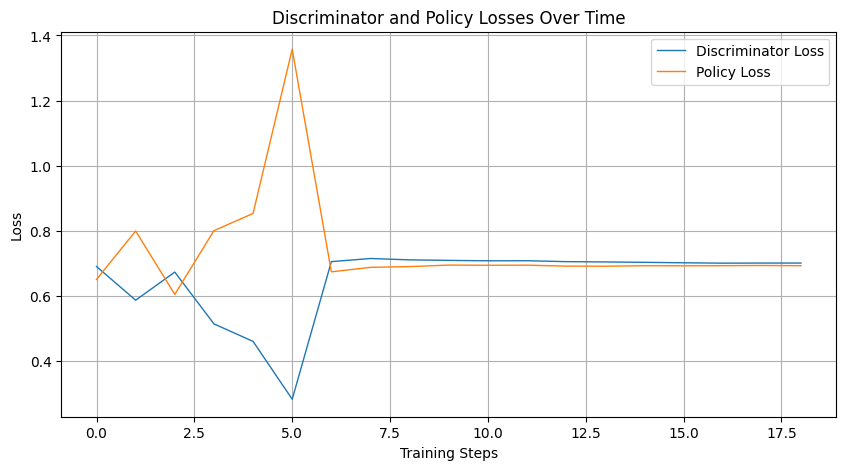

In [2]:
time = datetime.now().strftime("%d_%m_%H_%M_%S")
path = GAN_WEIGHTS_PATH /  f"policy_net_weights_{time}.pth"
torch.save(policy, path)
print(f"policy stored in: {path}")

plt.figure(figsize=(10, 5))
plt.plot(losses["disc"], label="Discriminator Loss", linewidth=1)
plt.plot(losses["pol"], label="Policy Loss", linewidth=1)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Discriminator and Policy Losses Over Time")
plt.legend()
plt.grid(True)

path = f"gan_plots/loss_{time}.png"
plt.savefig(path, dpi=300, bbox_inches="tight")
plt.show()

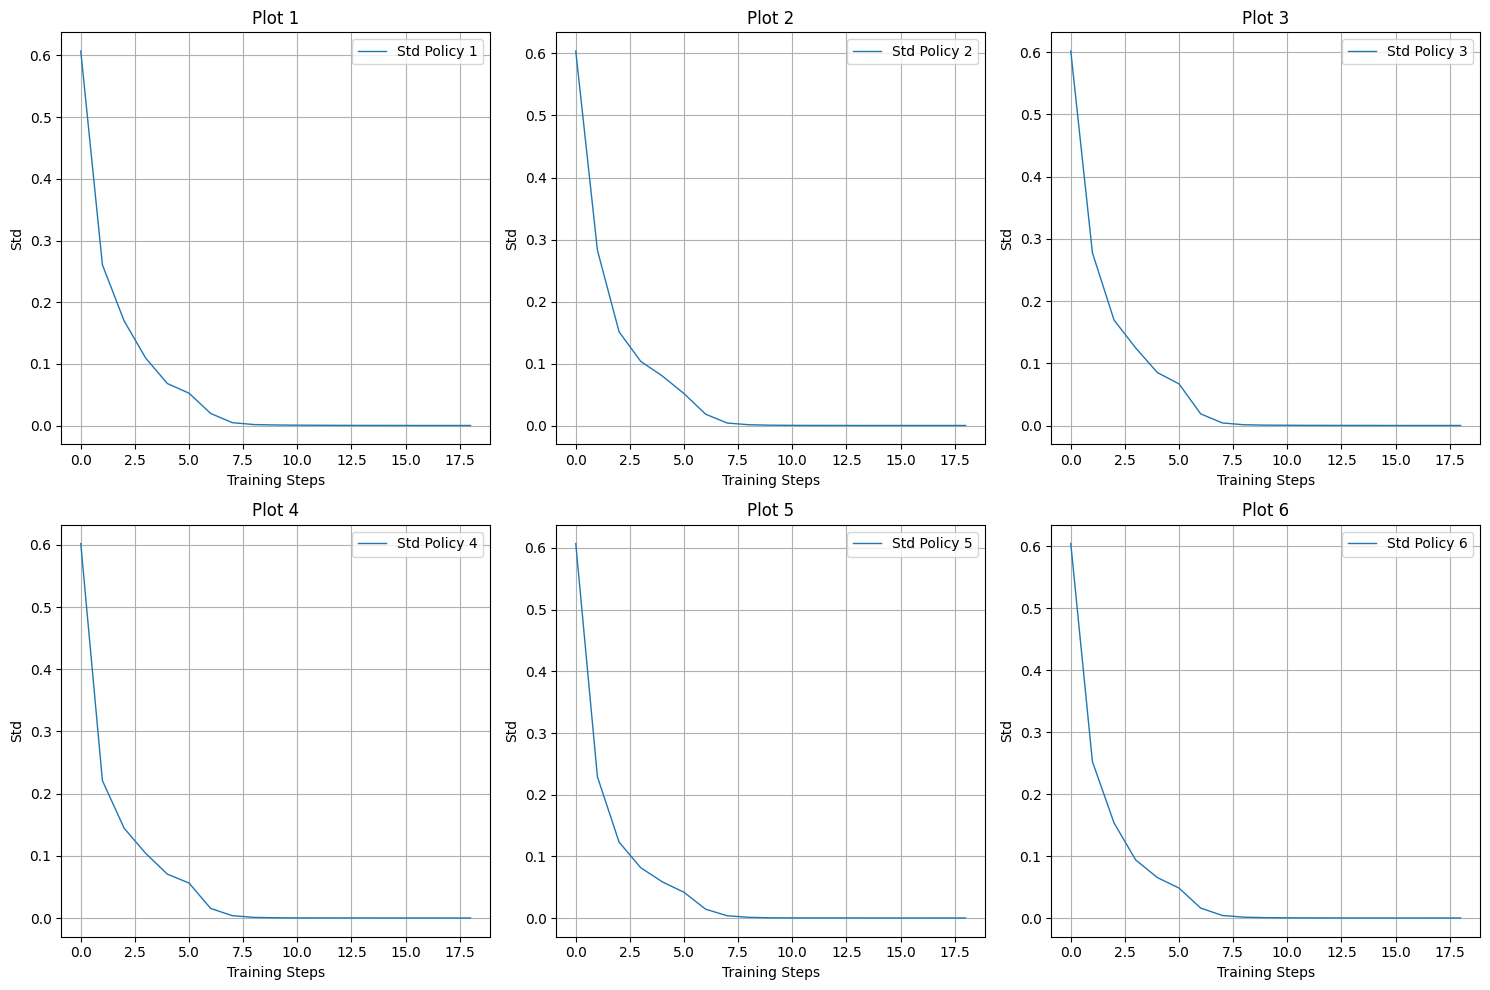

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easier indexing (axes is a 2D array)
axes = axes.flatten()

for i in range(6):
    std_losses = [l[i] for l in losses["p_std"]]  # Extract data for the ith plot
    
    # Plot on the ith axis
    axes[i].plot(std_losses, label=f"Std Policy {i+1}", linewidth=1)
    axes[i].set_title(f"Plot {i+1}")
    axes[i].set_xlabel("Training Steps")
    axes[i].set_ylabel("Std")
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Load GAN

In [5]:
from trpo import try_policy
from gan import *
import torch

def get_mean_std(dataloader):
    for batch in dataloader:
        return batch["state_mean"][0] , batch["state_std"][0]

dataloader = get_dataloader(batch_size=32)
mean, std = get_mean_std(dataloader)
# loaded_policy = torch.load("gan_weights/policy_net_weights_23_11_20_35_55.pth")
loaded_policy = policy
rewards = try_policy(loaded_policy, normalize_state=True, mean=mean, std=std)
print(rewards)

/Users/anthony/Documents/UW/Classes/2024/FA24/CSE543/Project/GenPol/gan.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(EXPERT_DATA_STATES_PATH.as_p

-1330.4837335793272


In [2]:
try_policy(loaded_policy, normalize_state=True, mean=mean, std=std)

np.float64(-98.39907559550528)

In [4]:
from utils import *

states = torch.load(EXPERT_DATA_STATES_PATH.as_posix())
actions = torch.load(EXPERT_DATA_ACTIONS_PATH.as_posix())
rewards = torch.load(EXPERT_DATA_REWARDS_PATH.as_posix())
next_states = torch.load(EXPERT_DATA_NEXT_STATES_PATH.as_posix())

def get_mean_std(dataloader):
    for batch in dataloader:
        return batch["state_mean"][0] , batch["state_std"][0]
mean, std = get_mean_std(dataloader)
normalized_states = normalize(states, mean, std)

actions_gan = policy.take_action(normalized_states)

# print_tensor_statistics(states)
# print_tensor_statistics(normalized_states)
print_tensor_statistics(actions_gan)
print_tensor_statistics(actions)

Index        Min        Max       Mean        Std
---------------------------------------------
0        -2.8597    19.9664    -0.0494     0.8457
1       -15.9511     4.4719     0.0371     0.9359
2        -3.7445    12.6745    -0.0066     0.9546
3        -6.5956     8.2608    -0.1012     0.8375
4        -4.0024     5.5284     0.0480     0.9141
5       -24.0895     6.6372     0.0540     0.8634
Index        Min        Max       Mean        Std
---------------------------------------------
0        -1.5160     1.8710     0.4738     0.5583
1        -1.3304     1.2896     0.0363     0.6129
2        -1.6314     1.8132     0.2140     0.4622
3        -0.9688     2.1029     0.3431     0.4653
4        -1.6621     1.9602     0.1219     0.5820
5        -1.4028     1.7619     0.3119     0.3673


/var/folders/nr/lfk3812x5593gr3r977z3s500000gn/T/ipykernel_22470/2342623973.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(EXPERT_DATA_STATES_PATH.a